# Titanic Survivor Liklihood Prediction

## Introduction

Welcome to this Endevour, a culmination of efforts in the <b>PFDS</b> course. In this assignment, we delve into the intriguing world of <b>predictive modeling</b>, employing the renowned <b><u>Titanic dataset</u></b>. Our goal is to construct a <b>robust predictive model</b> capable of determining the <b><u><i>likelihood of survival</i></u></b> for passengers aboard the ill-fated Titanic.

The <b><u>Titanic dataset</u></b> is a classic in the realm of data science, offering a rich tapestry of information about passengers, their socio-economic status, and survival outcomes. Leveraging this dataset, we embark on a journey through the essential steps of <b>data exploration</b>, <b>preprocessing</b>, <b>feature engineering</b>, and <b>model development</b>. Along the way, we'll employ various machine learning techniques to train and evaluate our predictive model.

This notebook serves as a comprehensive documentation of our analytical process, providing insights into the decisions made, challenges encountered, and the methodologies employed. Through meticulous coding and detailed explanations, we aim to not only showcase our technical proficiency but also our understanding of the underlying principles of predictive modeling.

Throughout this assignment, we adhere to the best practices of data science, emphasizing clarity, reproducibility, and thoughtful analysis. As we traverse each section, we encourage you to explore the code, interpret the results, and gain a deeper understanding of the intricacies involved in building a predictive model.

Let's set sail into the world of data science and uncover the patterns that may illuminate the factors contributing to survival on the Titanic. May this notebook be a testament to our dedication to mastering the foundations of data science and our ability to apply these skills to real-world datasets.

In [1]:
# Library Imports

import pandas as pd
import json
import pickle
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc, roc_curve
import mlflow
from matplotlib import pyplot as plt
from warnings import filterwarnings

filterwarnings('ignore')

## Utility Functions
This is library of custom functions developed to help in data cleaning, preprocessing and making data model ready.

In [2]:
def read_file(path, logger, sheet_name = 0, usecols = None, concat_sheets = False):
    """
    Description : This function reads the file present in the specified path and returns the dataframe in case of csv or excel files 
    and dictionary in case of json files.

    Inputs:
        path [STRING] : The path to the file to be read.
        logger [LOGGING.LOGGER] : The logger instance to keep track of errors and other information for debugging.
        sheet_name [INTEGER / STRING] : The qualified index or name of sheet in case of excel files.
        usecols [STRING] : The column indexes to be subsetted in entire excel file.
        concat_sheets [BOOLEAN] : If the sheets present in excel file needs to be concatenated into single dataframe.

    Outputs:
        data [DATAFRAME / DICTIONARY] : The contents of file in dataframe (in case of CSV or Excel) or in Dictionary (in case of JSON) 
    """
    file_extension = path.split('.')[-1]
    logger.info(f"The file extension is {file_extension}!")
    if file_extension == 'csv':
        try:
            data = pd.read_csv(path)
            logger.info(f"The file at path {path} read successfully with {data.shape[0]} rows and {data.shape[1]} columns!")
        except Exception as e:
            logger.error(f"The read of file at path {path} failed due to {e}!")
    elif file_extension == 'xlsx':
        try:
            data = pd.read_excel(path, sheet_name = sheet_name, usecols = usecols)
            logger.info(f"The file at path {path} read successfully with {data.shape[0]} rows and {data.shape[1]} columns!")
            if concat_sheets == True:
                concated_data = pd.DataFrame()
                for key in data:
                    concated_data = pd.concat([concated_data, data[key]] , axis = 0, ignore_index = True)
            data = concated_data.copy()
        except Exception as e:
            logger.error(f"The read of file at path {path} failed due to {e}!")
    elif file_extension == 'json':
        try:
            with open(path, "r") as fd:
                data = json.load(fd)
            logger.info(f"The file at path {path} read successfully!")
        except Exception as e:
            logger.error(f"The read of file at path {path} failed due to {e}!")
    else:
        logger.error(f"The extension {file_extension} is not supported!")
        data = pd.DataFrame()
    return data

def data_type_conversion(data, logger, mapping):
    """
    Description : The function is reponsible to cast the columns into specific data types as specified in mapping file.

    Inputs:
        data [DATAFRAME] : The data in which data type conversion will be applied.
        logger [LOGGING.LOGGER] : The logger instance to keep track of errors and other information for debugging.
        mapping [DICTIONARY] : The mapping having keys as column names and values as target data type of the columns.

    Outputs:
        data [DATAFRAME] : TRansformed data.
    """
    logger.info(f"Explicitly converting the data type of columns leveraging {mapping}")
    for column in mapping.keys():
        try:
            data[column] = data[column].astype(mapping[column])
            logger.info(f"Data type conversion for {column} into {mapping[column]} completed successfully!")
        except Exception as e:
            logger.error(f"Data type conversion for {column} into {mapping[column]} Failed due to {e}!")
    return data

def string_encoding(data, logger, string_columns):
    """
    Description : The function is reponsible to converting the columns having string data into one-hot vector encoded format.

    Inputs:
        data [DATAFRAME] : The data in which string encoding will be applied.
        logger [LOGGING.LOGGER] : The logger instance to keep track of errors and other information for debugging.
        string_columns [LIST] : The list of columns of string type for which one-hot vector encoding needs to be applied.

    Outputs:
        data [DATAFRAME] : TRansformed data.
    """
    logger.info(f"converting the string columns into neumeric features!")
    try:
        data = pd.get_dummies(data, columns = string_columns)
        logger.info(f"convertion of string columns {string_columns} into neumeric features completed successfully!")
    except Exception as e:
        logger.error(f"convertion of string columns {string_columns} into neumeric features failed due to {e}!")
    return data

def missing_data_imputation(data, logger, column, method = "median"):
    """
    Description : The function is reponsible to impute the NaNs present in the column of the data with appropriate values
    based on the choice of method.

    Inputs:
        data [DATAFRAME] : The data in which missing data imputation will be applied.
        logger [LOGGING.LOGGER] : The logger instance to keep track of errors and other information for debugging.
        column [STRING] : The column in which missing data imputation will be applied.
        method [STRING] : Specifies the method through which the NaNs will be replaced.
                        - for method = 'mean', NaNs are replaced with mean of non-NaN records of the column.
                        - for method = 'median', NaNs are replaced with median of non-NaN records of the column.
                        - for method = 'mode', NaNs are replaced with mode of non-NaN records of the column.

    Outputs:
        data [DATAFRAME] : TRansformed data.
    """
    assert method in ['median', 'mean', 'mode'], "Only 'median', 'mean' and 'mode' inputation methods are supported!"
    logger.info(f"Imputing missing values for {column} with {method}!")
    if method == 'mean':
        try:
            data[column].fillna(data[column].mean(), inplace = True)
            logger.info(f"Missing value imputation for {column} completed successfully!")
        except Exception as e:
            logger.info(f"Missing value imputation for {column} failed due to {e}!")
    elif method == 'median':
        try:
            data[column].fillna(data[column].median(skipna = True), inplace = True)
            logger.info(f"Missing value imputation for {column} completed successfully!")
        except Exception as e:
            logger.info(f"Missing value imputation for {column} failed due to {e}!")
    else:
        try:
            data[column].fillna(data[column].mode(dropna = True)[0], inplace = True)
            logger.info(f"Missing value imputation for {column} completed successfully!")
        except Exception as e:
            logger.info(f"Missing value imputation for {column} failed due to {e}!")
    return data

def create_quantile_feature(data, logger, column, q = 10):
    """
    Description : The function is reponsible to create the quantile based trend features.

    Inputs:
        data [DATAFRAME] : The data in which new feature will be added.
        logger [LOGGING.LOGGER] : The logger instance to keep track of errors and other information for debugging.
        column [STRING] : The column which will be transformed to create the new feature.
        q [INTEGER] : The quantile buckets that needs to be made in the data.

    Outputs:
        data [DATAFRAME] : TRansformed data.
    """
    logger.info(f"Creating quantile feature with q = {q} for {column} column!")
    try:
        data[column + f"_{q}_quantile_feature"] = pd.qcut(data[column], q = q, labels = False, retbins = False).tolist()
        logger.info(f"Created quantile feature with q = {q} for {column} column successfully!")
    except Exception as e:
        logger.info(f"quantile feature with q = {q} for {column} column creation failed due to {e}!")
    return data

def split_train_validation(data, logger, features, target, test_size = 0.2, random_state = 45, shuffle = True):
    """
    Description : The function is reponsible to split the input dataframe into training and validation sets.

    Inputs:
        data [DATAFRAME] : The data which will be splitted into two sets.
        logger [LOGGING.LOGGER] : The logger instance to keep track of errors and other information for debugging.
        features [LIST] : The list of column names to be used as input feature to the model.
        target [STRING] : The target column which will be output of the predictive model. 

    Outputs:
        data [DATAFRAME] : TRansformed data.
    """
    X_train, X_val, Y_train, Y_val = train_test_split(data[features] , data[target], test_size = test_size, random_state = random_state,shuffle=shuffle)
    return pd.DataFrame(data = X_train, columns = features), pd.DataFrame(data = X_val, columns = features), Y_train, Y_val

def normalize(data, logger, scaler_path, fit_standard_scaler = True):
    """
    Description : The function is reponsible to scale the data such that the mean is 0 and standard deviation is 1.

    Inputs:
        data [DATAFRAME] : The data in which scaling will be applied.
        logger [LOGGING.LOGGER] : The logger instance to keep track of errors and other information for debugging.
        scaler_path [STRING] : The path at which the standard scaler object will be saved or picked from.
        fit_standard_scaler [BOOLEAN] : The flag that tells the function wheather to fit and transform a new instance of
            standard scaler or use the pretrained one.

    Outputs:
        data [DATAFRAME] : TRansformed data.
    """
    if fit_standard_scaler == True:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
        data = pd.DataFrame(data = data, columns = scaler.feature_names_in_)
        with open(scaler_path, "wb") as fd:
            pickle.dump(scaler, fd)
    else:
        with open(scaler_path, "rb") as fd:
            scaler = pickle.load(fd)
        data = scaler.transform(data)
        data = pd.DataFrame(data = data, columns = scaler.feature_names_in_)
    return data

def plot_roc_curve(fpr, tpr, roc_curve_path = 'roc_curve.png'):
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, marker='.')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(roc_curve_path)
    plt.plot()
    # plt.close()

def plot_pr_curve(recall, precision, pr_curve_path = 'pr_curve.png'):
    plt.figure(figsize=(5, 5))
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(pr_curve_path)
    plt.plot()
    # plt.close()

def log_metrics(actual, predicted_labels, predicted_scores, model, model_name, random_state, val_ratio):
    """
    TBU
    """
    # mlflow.set_tracking_uri('http://127.0.0.1:5000')
    # mlflow.set_experiment("PFDS Assignment")
    # with mlflow.start_run() as run:
    #     mlflow.log_param("Model Name", model_name)
    #     mlflow.log_param("Random State", random_state)
    #     mlflow.log_param("validation_split_ratio", val_ratio)
    #     mlflow.log_artifact("../configuration/pipeline_configuration.json")
    #     mlflow.log_metric("Accuracy", accuracy_score(actual, predicted_labels))
    #     mlflow.log_metric("Precision", precision_score(actual, predicted_labels))
    #     mlflow.log_metric("Recall", recall_score(actual, predicted_labels))
    #     mlflow.log_metric("F1 Score", f1_score(actual, predicted_labels))
    #     mlflow.log_metric("ROC AUC Score", roc_auc_score(actual, predicted_scores))
    #     precision, recall, thresholds = precision_recall_curve(actual, predicted_scores)
    #     mlflow.log_metric("PR AUC Score", auc(recall, precision))
    #     fpr, tpr, _ = roc_curve(actual, predicted_scores)
    #     plot_roc_curve(fpr, tpr, roc_curve_path = 'roc_curve.png')
    #     plot_pr_curve(recall, precision, pr_curve_path = 'pr_curve.png')
    #     mlflow.log_artifact("roc_curve.png")
    #     mlflow.log_artifact("pr_curve.png")
    #     mlflow.sklearn.log_model(model, "model")
    print(f"====================== {model_name} ======================")
    print("Model Name : ", model_name)
    print("Accuracy : ", accuracy_score(actual, predicted_labels))
    print("Precision : ", precision_score(actual, predicted_labels))
    print("Recall : ", recall_score(actual, predicted_labels))
    print("F1 Score : ", f1_score(actual, predicted_labels))
    print("ROC AUC Score : ", roc_auc_score(actual, predicted_scores))
    precision, recall, thresholds = precision_recall_curve(actual, predicted_scores)
    print("PR AUC Score : ", auc(recall, precision))
    fpr, tpr, _ = roc_curve(actual, predicted_scores)
    plot_roc_curve(fpr, tpr, roc_curve_path = 'roc_curve.png')
    plot_pr_curve(recall, precision, pr_curve_path = 'pr_curve.png')
    print("============================================================")

## Data Preprocessing
In this stage of the model iteration we will invoke specific helper function (created in previous step) on the train and test data sets.

### Instantiate logger instance

In [3]:
logging.basicConfig(format = '[%(asctime)s] : %(levelname)s -> %(message)s', level = logging.DEBUG, filename = '../logs/pipeline_log.log')
logger = logging.getLogger(__name__)

### Read Configuration file

In [4]:
config = read_file("../configuration/pipeline_configuration.json", logger)

### Read datasets

In [5]:
train_data = read_file(config["data_directory_path"] + config["train_dataset_name"], logger)
test_data = read_file(config["data_directory_path"] + config["test_dataset_name"], logger)

### Data Type conversion

In [6]:
train_data = data_type_conversion(train_data, logger, config["type_conversion_mpping"])
test_data = data_type_conversion(test_data, logger, config["type_conversion_mpping"])

### String Encoding

In [7]:
train_data = string_encoding(train_data, logger, config["string_columns"])
test_data = string_encoding(test_data, logger, config["string_columns"])

### Missing data Imputation

In [8]:
for column in config["imputation_method_mapping"].keys():
    train_data = missing_data_imputation(train_data, logger, column, method = config["imputation_method_mapping"][column])
    test_data = missing_data_imputation(test_data, logger, column, method = config["imputation_method_mapping"][column]) 

### Feature Engineering
Creating quartile features for Fare and Age to capture the trend.

In [9]:
for feature_eng_column in config["feature_engineering_columns"]:
    train_data = create_quantile_feature(train_data, logger, feature_eng_column, q = 4)
    test_data = create_quantile_feature(test_data, logger, feature_eng_column, q = 4)

### Drop unnecessary columns

In [10]:
train_data_model_data = train_data.drop(columns = config["drop_columns"])
test_data_model_data = test_data.drop(columns = config["drop_columns"])

### Train-Validation Split of data

In [11]:
features = list(set(train_data_model_data.columns).difference(set([config["target_column"]])))
target = config["target_column"]
X_train, X_val, Y_train, Y_val = split_train_validation(train_data_model_data, logger, features, target)

### Normalize / Scale the data for model

In [12]:
X_train = normalize(X_train[features], logger, config["data_directory_path"] + config["scaler_file_name"], fit_standard_scaler = True)
X_val = normalize(X_val[features], logger, config["data_directory_path"] + config["scaler_file_name"], fit_standard_scaler = False)
X_test = normalize(test_data_model_data[features], logger, config["data_directory_path"] + config["scaler_file_name"], fit_standard_scaler = False)

## Model Iterations

====================== Logistic Regression Base ======================
Model Name :  Logistic Regression Base
Accuracy :  0.8212290502793296
Precision :  0.734375
Recall :  0.7580645161290323
F1 Score :  0.7460317460317459
ROC AUC Score :  0.87351805900193
PR AUC Score :  0.8079815788919236


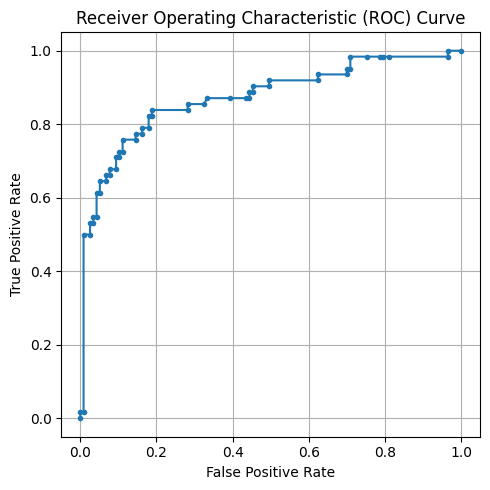

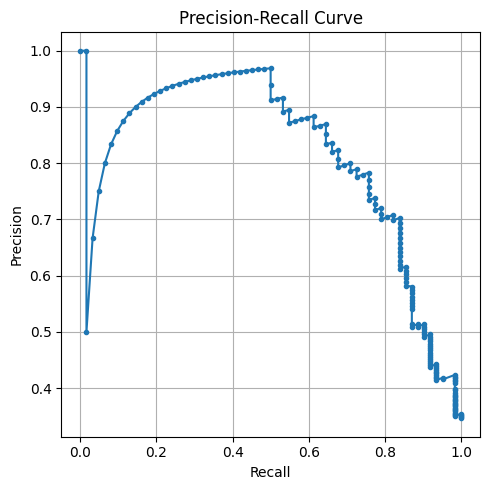

In [13]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)
predictions_label = model.predict(X_val)
predictions_score = model.predict_proba(X_val)[:, 1]
log_metrics(Y_val, predictions_label, predictions_score, model, "Logistic Regression Base", 45, 0.2)

====================== Decision Tree Base ======================
Model Name :  Decision Tree Base
Accuracy :  0.7541899441340782
Precision :  0.6097560975609756
Recall :  0.8064516129032258
F1 Score :  0.6944444444444445
ROC AUC Score :  0.7750206782464848
PR AUC Score :  0.7446306211704604


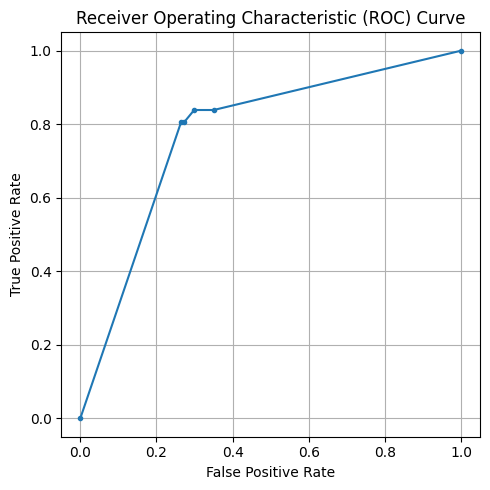

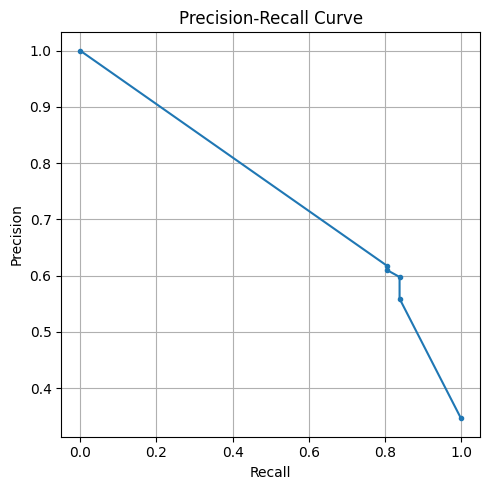

In [14]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state = 45)
model.fit(X_train, Y_train)
predictions_label = model.predict(X_val)
predictions_score = model.predict_proba(X_val)[:, 1]
log_metrics(Y_val, predictions_label, predictions_score, model, "Decision Tree Base", 45, 0.2)

====================== Random Forest Base ======================
Model Name :  Random Forest Base
Accuracy :  0.8435754189944135
Precision :  0.75
Recall :  0.8225806451612904
F1 Score :  0.7846153846153845
ROC AUC Score :  0.914598842018197
PR AUC Score :  0.8833408944802621


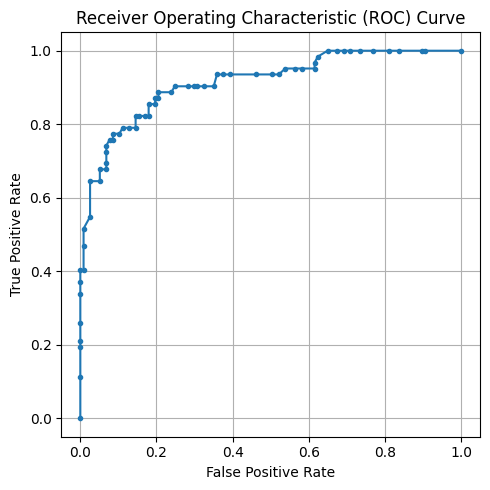

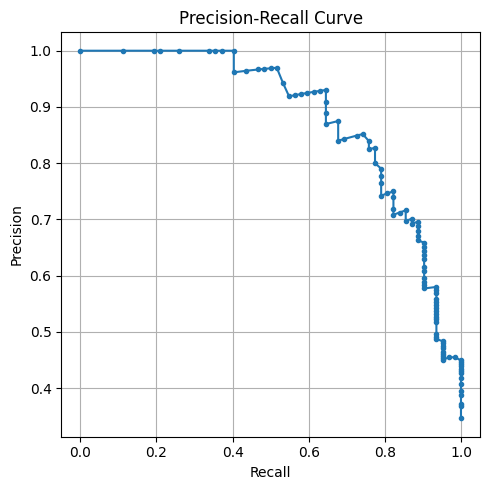

In [15]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs = -1)
model.fit(X_train, Y_train)
predictions_label = model.predict(X_val)
predictions_score = model.predict_proba(X_val)[:, 1]
log_metrics(Y_val, predictions_label, predictions_score, model, "Random Forest Base", 45, 0.2)